In [1]:
import torch

In [2]:
# read csv with pandas
import pandas as pd

data_path = '../data_input/train.csv'
df = pd.read_csv(data_path, usecols=['id', 'text', 'label'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157789 entries, 0 to 157788
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      157789 non-null  object
 1   text    157789 non-null  object
 2   label   157789 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


In [3]:
context_length = 32

In [4]:
# split X and Y into train and val, stratify by Y
import sys

sys.path.append(".")
from data import get_train_test_split

Xtr, Xval, Ytr, Yval = get_train_test_split(
    df["text"], df["label"], context_length=context_length, test_size=0.2
)

Vocab size: 5001


In [5]:
Xtr.shape, Xval.shape

(torch.Size([126231, 32]), torch.Size([31558, 32]))

In [6]:
import torch.nn as nn

class FlattenConsecutive(nn.Module):
  def __init__(self, n):
    super().__init__()
    self.n = n
    
  def forward(self, x):
    # forward to torch batchnorm, expects:
    # Input: (N,C) or (N,C,L), where N is the batch size, 
    # C is the number of features or channels, and L is the sequence length
    # output: (N, C, L)
    
    N, L, C = x.shape
    try: 
      x = x.view(N, L//self.n, C*self.n)
    except Exception as e:
      print(f"Error: {e}")
      print(f"Input shape: {x.shape}")
      print(f"Output shape: {N, L//self.n, C*self.n}")
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  

In [7]:
# x = x.view(N, L//self.n, C*self.n)
t = torch.randn(32, 16, 64)
t.view(32, 16//2, 64*2).shape

torch.Size([32, 8, 128])

In [8]:
class BatchNorm1d(nn.Module):
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    super().__init__()
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def forward(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def _parameters(self):
    return [self.gamma, self.beta]

In [92]:
n_hidden = 32 # the number of neurons in the hidden layer of the MLP
vocab_size = 5001
n_embd = 16
n_consecutive = 4
batch_size = 32

In [93]:
class WaveModel(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, n_consecutive, n_classes=5):
        super().__init__()
        # Define the layers
        self.n_hidden = n_hidden
        self.embedding = nn.Embedding(vocab_size, n_embd)
        self.embedding.weight.data = self.embedding.weight.data / (n_embd * n_consecutive) ** 0.5
        self.flatten1 = FlattenConsecutive(n_consecutive)
        self.linear1 = nn.Linear(n_embd * n_consecutive, n_hidden, bias=False)
        self.linear1.weight.data = self.linear1.weight.data * 5/3 / (n_hidden * n_consecutive) ** 0.5
        self.batch_norm1 = BatchNorm1d(n_hidden)
        self.tanh1 = nn.Tanh()
        
        
        self.flatten2 = FlattenConsecutive(n_consecutive)
        self.linear2 = nn.Linear(n_hidden * n_consecutive, n_hidden, bias=False)
        self.linear2.weight.data = self.linear2.weight.data * 5/3 / (n_hidden * n_consecutive) ** 0.5
        self.batch_norm2 = BatchNorm1d(n_hidden)
        self.tanh2 = nn.Tanh()
        
        n_consecutive = 2
        self.flatten3 = FlattenConsecutive(n_consecutive)
        self.linear3 = nn.Linear(n_hidden * n_consecutive, n_hidden, bias=False)
        self.linear3.weight.data = self.linear3.weight.data * 5/3 / (n_hidden) ** 0.5
        self.batch_norm3 = BatchNorm1d(n_hidden)
        self.tanh3 = nn.Tanh()
        
        self.output_linear = nn.Linear(n_hidden, n_classes)
        self.output_linear.weight.data = self.output_linear.weight.data * 0.1
    
    def forward(self, x):
        # Step 1: Embedding layer
        x = self.embedding(x)
        
        # Step 2: First flattening, linear, batch normalization, and activation layers
        x = self.flatten1(x)
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.tanh1(x)
        
        # Step 3: Second flattening, linear, batch normalization, and activation layers
        x = self.flatten2(x)
        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.tanh2(x)
        
        # Step 4: Third flattening, linear, batch normalization, and activation layers
        x = self.flatten3(x)
        x = self.linear3(x)
        x = self.batch_norm3(x)
        x = self.tanh3(x)
        
        # Step 5: Output linear layer
        x = self.output_linear(x)
        
        return x

In [94]:
model = WaveModel(vocab_size, n_embd, n_hidden, n_consecutive)
sum([p.nelement() for p in model.parameters()])

88373

In [95]:
layers = list(model.modules())[1:]

In [96]:
# Define the forward hook function
def forward_hook(module, input, output):
    module.out = output  # Store output in the module itself
    module.out.retain_grad()  # Tell PyTorch to keep the gradient

In [97]:
# loop over model layers except the last one
for layer in layers[:-1]:
  layer.register_forward_hook(forward_hook)
  print(layer)

Embedding(5001, 16)
FlattenConsecutive()
Linear(in_features=64, out_features=32, bias=False)
BatchNorm1d()
Tanh()
FlattenConsecutive()
Linear(in_features=128, out_features=32, bias=False)
BatchNorm1d()
Tanh()
FlattenConsecutive()
Linear(in_features=64, out_features=32, bias=False)
BatchNorm1d()
Tanh()


In [105]:
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Initialize the AdamW optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # Set initial learning rate and weight decay

# same optimization as last time
max_steps = 20000
lossi = []
ud = []
parameters = list(model.parameters())

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  loss.backward()
  
  # Update parameters using the AdamW optimizer
  optimizer.step()
  
  # track stats
  if i % 5000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    lr = optimizer.param_groups[0]['lr']
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])
    
  # Reset gradients to zero
  if not i == max_steps - 1:
    optimizer.zero_grad()

      0/  20000: 0.5771
   5000/  20000: 0.8525
  10000/  20000: 0.8034
  15000/  20000: 0.9182


layer 4 (Tanh): mean -0.00, std 0.60, saturated: 5.29%
layer 8 (Tanh): mean -0.00, std 0.64, saturated: 3.42%
layer 12 (Tanh): mean -0.00, std 0.66, saturated: 1.56%


Text(0.5, 1.0, 'activation distribution')

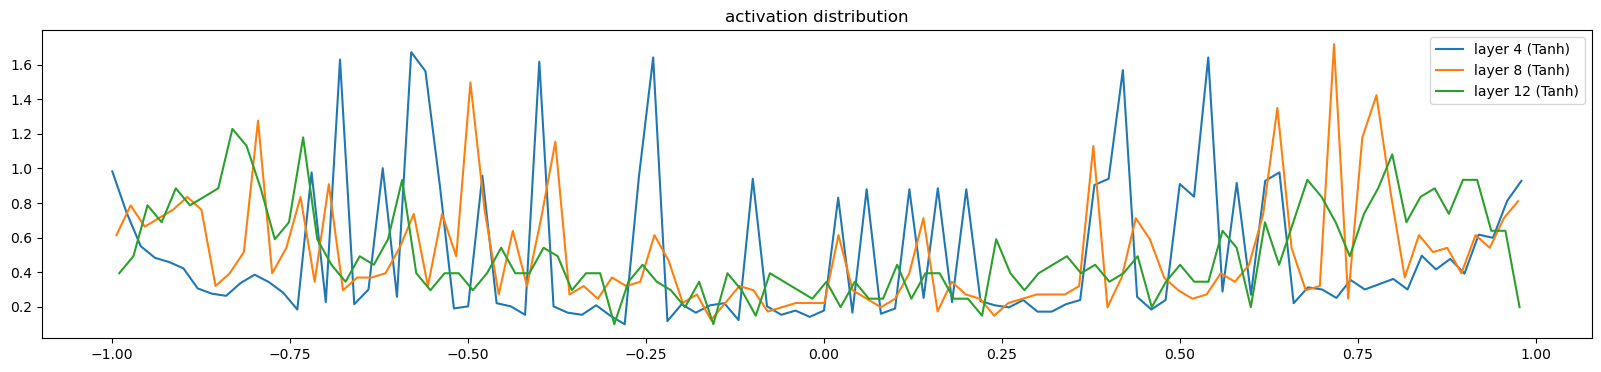

In [106]:
import matplotlib.pyplot as plt

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, nn.Tanh):
    t = layer.out
    print('layer %d (%s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 4 (      Tanh): mean -0.000000, std 4.043098e-03
layer 8 (      Tanh): mean -0.000000, std 5.324859e-03
layer 12 (      Tanh): mean -0.000114, std 5.313578e-03


Text(0.5, 1.0, 'gradient distribution')

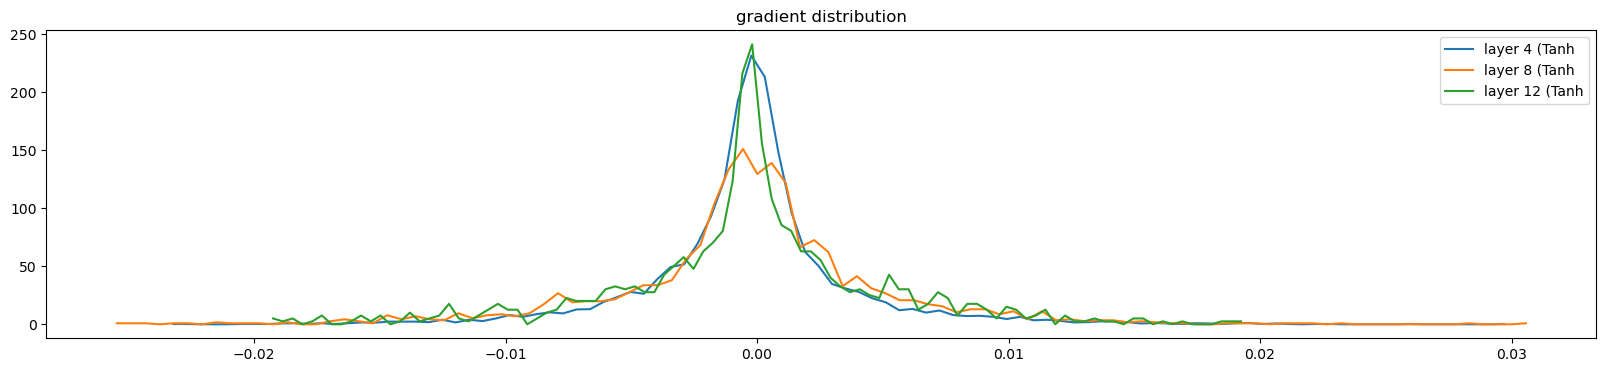

In [107]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, nn.Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight (5001, 16) | mean -0.000000 | std 7.307405e-03 | grad:data ratio 3.478013e-02
weight   (32, 64) | mean +0.001432 | std 3.017591e-02 | grad:data ratio 1.799961e-01
weight  (32, 128) | mean -0.000016 | std 9.539762e-03 | grad:data ratio 5.681345e-02
weight   (32, 64) | mean -0.000145 | std 9.623395e-03 | grad:data ratio 5.684603e-02
weight    (5, 32) | mean -0.000000 | std 3.112566e-02 | grad:data ratio 1.315795e-01


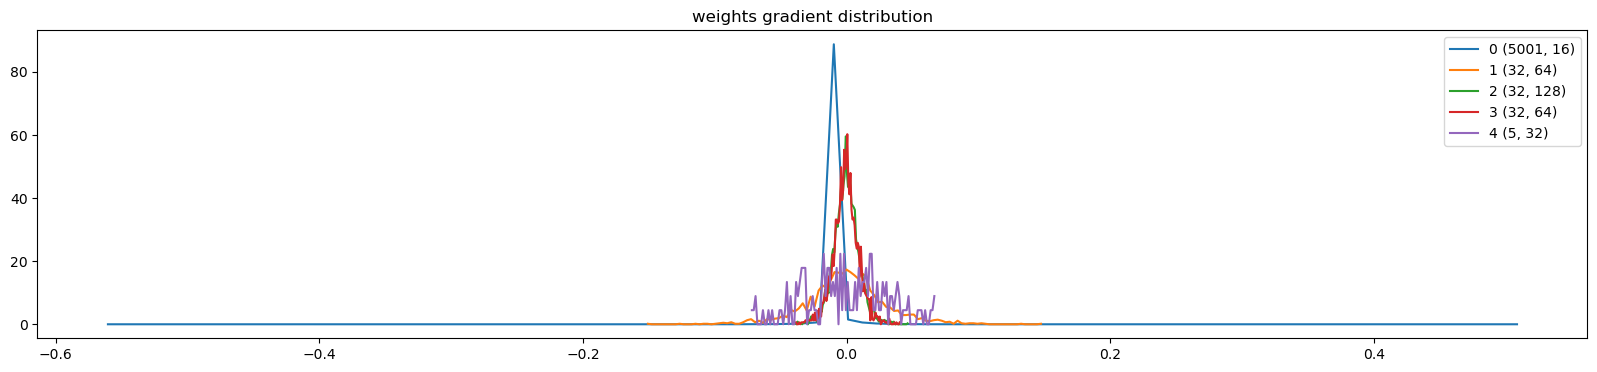

In [108]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(model.parameters()):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

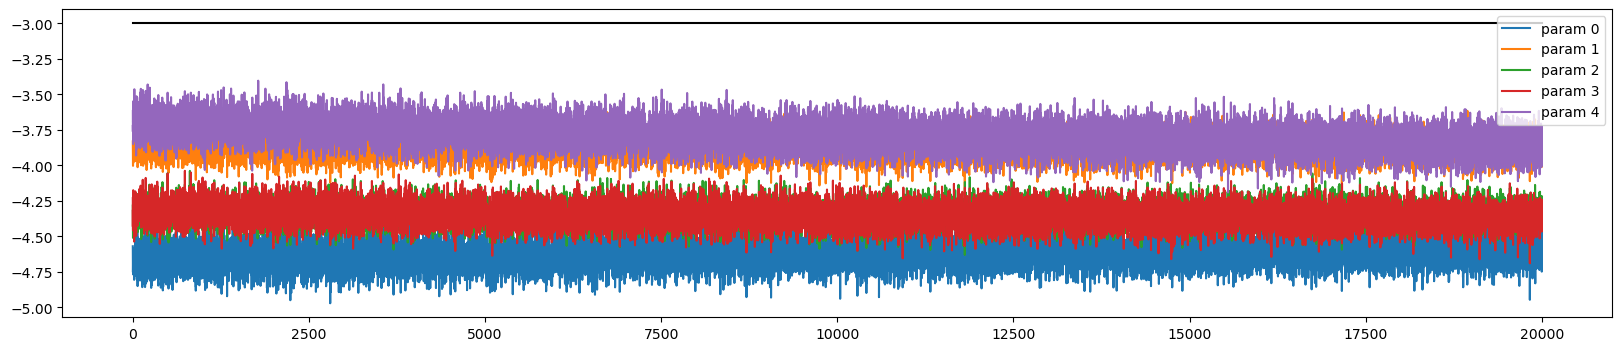

In [109]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters()):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [110]:
# with torch.no_grad():
    # train validation loss
outputs1 = model(Xtr)
loss = F.cross_entropy(outputs1, Ytr)
print(f'Training loss: {loss.item():.4f}')

outputs = model(Xval)
loss = F.cross_entropy(outputs, Yval)
print(f'Validation loss: {loss.item():.4f}')

Training loss: 0.7900
Validation loss: 1.2613


tensor(1.1228, grad_fn=<NllLossBackward0>)  
tensor(1.0828, grad_fn=<NllLossBackward0>)  
tensor(1.0767, grad_fn=<NllLossBackward0>) on mlpc

In [111]:
from sklearn.metrics import classification_report

Y_pred = outputs1.argmax(dim=1).detach().numpy()
Y_true = Ytr.numpy()

print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78     25414
           1       0.61      0.61      0.61     25847
           2       0.60      0.56      0.58     25349
           3       0.67      0.66      0.66     24975
           4       0.79      0.81      0.80     24646

    accuracy                           0.69    126231
   macro avg       0.69      0.69      0.69    126231
weighted avg       0.69      0.69      0.69    126231

